In [1]:
# imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

#notebook settings
pd.set_option('display.max_columns', None)

from scipy.stats import uniform, randint

# building a pipeline to preprocess the data
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve, validation_curve, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier


In [2]:
import pandas as pd

# Paths to feature files
train_path = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/prepared_claims_data_train.csv"
val_path = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/prepared_claims_data_val.csv"
test_path = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/prepared_claims_data_test.csv"

# Paths to target files
ytrain_path = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/y_train_encoded.csv"
yval_path = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/y_val_encoded.csv"
ytest_path = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/y_test_encoded.csv"

# Load the feature datasets
X_train = pd.read_csv(train_path)
X_val = pd.read_csv(val_path)
X_test = pd.read_csv(test_path)

# Load the target datasets
y_train = pd.read_csv(ytrain_path)
y_val = pd.read_csv(yval_path)
y_test = pd.read_csv(ytest_path)

# Inspect loaded data
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)


X_train shape: (363063, 43) y_train shape: (363063, 2)
X_val shape: (91844, 43) y_val shape: (91844, 1)
X_test shape: (114806, 43) y_test shape: (114806, 1)


/var/folders/2m/t2s2zdt15tgd3q3dmyd7y88r0000gn/T/ipykernel_87065/973958481.py:16: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  X_test = pd.read_csv(test_path)


In [3]:
print(X_train.columns)

Index(['Unnamed: 0', 'Age at Injury', 'Attorney/Representative',
       'Average Weekly Wage', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'County of Injury', 'COVID-19 Indicator',
       'District Name', 'Gender', 'Industry Code Description',
       'Medical Fee Region', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Description', 'WCIO Part Of Body Description',
       'Zip Code', 'Number of Dependents', 'Cause Injury Category',
       'Nature of Injury Category', 'Body Part Category', 'Age_Group',
       'Wage_Group', 'Carrier Name Grouped', 'Lag_Time', 'Accident_to_C2_Lag',
       'Accident Date_Year', 'Accident Date_Month', 'Assembly Date_Month',
       'Assembly Date_Day', 'C-2 Date_Year', 'C-2 Date_Month', 'C-2 Date_Day',
       'Accident_Month_Sin', 'Accident_Month_Cos', 'Accident_Day',
       'Assembly_Year', 'Assembly_Month_Sin', 'Assembly_Month_Cos',
       'Assembly_Day', 'C-2_Month_Sin', 'C-2_Month_Cos', 'C-2_Day'],
      dtype='object')


# Encodings of the features

We decide to encode the variables as follows:
- __One-Hot Encoding:__ For variables with a small number of unique values (< 5); preferable because it treats each category independently and avoids introducing an artificial order.
- __Label Encoding:__ For variables with a larger number of categories or variables where there is a clear order or hierarchy.
- __Ordinal Encoding:__ For variables with a natural order or numeric-like scale.

| **Variable**                     | **Encoding Type**       | **Reason**                                                                 |
|----------------------------------|-------------------------|-----------------------------------------------------------------------------|
| Age at Injury                    | None                   | Numerical variable; leave as-is.                                           |
| Attorney/Representative          | One-Hot                | Binary categorical (Yes/No).                                               |
| Average Weekly Wage              | None                   | Numerical variable; leave as-is.                                           |
| Carrier Name                     | Label                  | High-cardinality categorical; use Label Encoding.                          |
| Carrier Type                     | Label                  | Nominal categorical; Label Encoding is efficient for lower cardinality.    |
| Claim Identifier                 | None                   | Unique identifier; leave as-is.                                            |
| Claim Injury Type                | Label                  | Multiclass target; Label Encoding is standard for targets.                 |
| County of Injury                 | Label                  | High-cardinality categorical; Label Encoding is better for efficiency.     |
| COVID-19 Indicator               | One-Hot                | Binary categorical (Yes/No).                                               |
| District Name                    | Label                  | Categorical variable, moderate cardinality; Label Encoding is efficient.   |
| Gender                           | One-Hot                | Binary categorical (Male/Female/Other).                                    |
| Industry Code Description        | Label                  | High-cardinality nominal; Label Encoding is preferred.                     |
| Medical Fee Region               | One-Hot                | Nominal categorical (regions); One-Hot avoids unintended ordinal meaning.  |
| WCIO Cause of Injury Code        | Label                  | Numerical but nominal; Label Encoding fits better for this use case.       |
| WCIO Nature of Injury Code       | Label                  | Numerical but nominal; Label Encoding works best.                          |
| WCIO Part Of Body Code           | Label                  | Numerical but nominal; Label Encoding works best.                          |
| Zip Code                         | Label                  | High-cardinality categorical; Label Encoding is efficient.                 |
| Number of Dependents             | None                   | Numerical variable; leave as-is.                                           |
| Lag_Time                         | None                   | Numerical variable; leave as-is.                                           |
| Accident_to_C2_Lag               | None                   | Numerical variable; leave as-is.                                           |
| Accident Date_Year               | None                   | Numerical variable; leave as-is.                                           |
| Accident Date_Month              | One-Hot                | Cyclical data; consider One-Hot or sin/cos transformations.                |
| Accident Date_Day                | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Assembly Date_Year               | None                   | Numerical variable; leave as-is.                                           |
| Assembly Date_Month              | One-Hot                | Cyclical data; consider One-Hot or sin/cos transformations.                |
| Assembly Date_Day                | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| C-2 Date_Year                    | None                   | Numerical variable; leave as-is.                                           |
| C-2 Date_Month                   | One-Hot                | Cyclical data; consider One-Hot or sin/cos transformations.                |
| C-2 Date_Day                     | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Accident_Year                    | None                   | Numerical variable; leave as-is.                                           |
| Accident_Month                   | One-Hot                | Cyclical data; consider One-Hot or sin/cos transformations.                |
| Accident_Month_Sin               | None                   | Already processed as cyclical; leave as-is.                                |
| Accident_Month_Cos               | None                   | Already processed as cyclical; leave as-is.                                |
| Accident_Day                     | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Assembly_Year                    | None                   | Numerical variable; leave as-is.                                           |
| Assembly_Month                   | One-Hot                | Cyclical data; consider One-Hot or sin/cos transformations.                |
| Assembly_Month_Sin               | None                   | Already processed as cyclical; leave as-is.                                |
| Assembly_Month_Cos               | None                   | Already processed as cyclical; leave as-is.                                |
| Assembly_Day                     | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| C-2_Year                         | None                   | Numerical variable; leave as-is.                                           |
| C-2_Month                        | One-Hot                | Cyclical data; consider One-Hot or sin/cos transformations.                |
| C-2_Month_Sin                    | None                   | Already processed as cyclical; leave as-is.                                |
| C-2_Month_Cos                    | None                   | Already processed as cyclical; leave as-is.                                |
| C-2_Day                          | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Cause Injury Category            | Label                  | Nominal categorical; Label Encoding is efficient.                          |
| Nature of Injury Category        | Label                  | Nominal categorical; Label Encoding is efficient.                          |
| Body Part Category               | Label                  | Nominal categorical; Label Encoding is efficient.                          |
| Age_Group                        | Ordinal                | Categorical with inherent order (e.g., Teen, Adult); Ordinal Encoding fits.|
| Wage_Group                       | Ordinal                | Categorical with inherent order (e.g., Low, Medium, High); Ordinal fits.   |
| Carrier Name Grouped             | Label                  | High-cardinality nominal; Label Encoding is efficient.                     |
| Claim Type Numeric               | None                   | Already encoded as numeric; leave as-is.                                   |


In [4]:
numerical_features = [
    'Age at Injury', 'Average Weekly Wage', 'Number of Dependents',
    'Lag_Time', 'Accident_to_C2_Lag', 'Accident Date_Year', 'Assembly Date_Day',
    'C-2 Date_Year', 'C-2 Date_Day', 'Accident_Month_Sin', 'Accident_Month_Cos',
    'Accident_Day', 'Assembly_Year', 'Assembly_Month_Sin', 'Assembly_Month_Cos',
    'Assembly_Day', 'C-2_Month_Sin', 'C-2_Month_Cos', 'C-2_Day'
]

## One Hot Encoding

In [5]:
onehot_features = [
    'Attorney/Representative', 'COVID-19 Indicator', 'Gender', 
    'Medical Fee Region', 'Accident Date_Month', 'Assembly Date_Month', 'C-2 Date_Month'
]

In [6]:
# Initialize OneHotEncoder
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Label Encoding

In [7]:
print("Columns in X_train:", X_train.columns.tolist())

Columns in X_train: ['Unnamed: 0', 'Age at Injury', 'Attorney/Representative', 'Average Weekly Wage', 'Carrier Name', 'Carrier Type', 'Claim Identifier', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code', 'Number of Dependents', 'Cause Injury Category', 'Nature of Injury Category', 'Body Part Category', 'Age_Group', 'Wage_Group', 'Carrier Name Grouped', 'Lag_Time', 'Accident_to_C2_Lag', 'Accident Date_Year', 'Accident Date_Month', 'Assembly Date_Month', 'Assembly Date_Day', 'C-2 Date_Year', 'C-2 Date_Month', 'C-2 Date_Day', 'Accident_Month_Sin', 'Accident_Month_Cos', 'Accident_Day', 'Assembly_Year', 'Assembly_Month_Sin', 'Assembly_Month_Cos', 'Assembly_Day', 'C-2_Month_Sin', 'C-2_Month_Cos', 'C-2_Day']


In [8]:
label_features = [
    'Carrier Name', 'Carrier Type', 'District Name', 'Industry Code Description',
    'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description',
    'WCIO Part Of Body Description', 'Zip Code', 'Cause Injury Category',
    'Nature of Injury Category', 'Body Part Category', 'Carrier Name Grouped']

In [9]:
# Check which label_features exist in X_train
missing_features = [col for col in label_features if col not in X_train.columns]
existing_features = [col for col in label_features if col in X_train.columns]

print("Missing features:", missing_features)
print("Existing features:", existing_features)

Missing features: []
Existing features: ['Carrier Name', 'Carrier Type', 'District Name', 'Industry Code Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code', 'Cause Injury Category', 'Nature of Injury Category', 'Body Part Category', 'Carrier Name Grouped']


In [10]:
print("Final label features:", label_features)

Final label features: ['Carrier Name', 'Carrier Type', 'District Name', 'Industry Code Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code', 'Cause Injury Category', 'Nature of Injury Category', 'Body Part Category', 'Carrier Name Grouped']


# Ordinal Encoding and Encoding and Scaling Pipeline

In [11]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
import pickle

# Define ordinal features and categories
ordinal_features = ['Age_Group', 'Wage_Group']  # Add ordinal features if applicable
ordinal_categories = [
    ['Teen', 'Young Adult', 'Adult', 'Middle-Aged Adult', 'Older Adult', 'Senior'],  # Age_Group
    ['Low', 'Below Average', 'Average', 'Above Average', 'High']  # Wage_Group
]

# Initialize and fit OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)

# Define transformations
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('scaler', StandardScaler())  # Optional scaling for one-hot encoded features
])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1)),
    ('scaler', StandardScaler())  # Scale the ordinal features
])

label_transformer = Pipeline(steps=[
    ('label', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('scaler', StandardScaler())  # Scale the label-encoded features
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scale numerical features
])

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('onehot', onehot_transformer, onehot_features),
    ('ordinal', ordinal_transformer, ordinal_features),
    ('label', label_transformer, label_features),
    ('num', numerical_transformer, numerical_features)  # Ensure numerical features are also scaled
])

# Apply the preprocessor: fit on training data and transform all datasets
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

# Save the preprocessor for future use
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

print("Validated feature groups:")
print("One-hot features:", onehot_features)
print("Label features:", label_features)
print("Numerical features:", numerical_features)
print("Ordinal features:", ordinal_features)

Validated feature groups:
One-hot features: ['Attorney/Representative', 'COVID-19 Indicator', 'Gender', 'Medical Fee Region', 'Accident Date_Month', 'Assembly Date_Month', 'C-2 Date_Month']
Label features: ['Carrier Name', 'Carrier Type', 'District Name', 'Industry Code Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code', 'Cause Injury Category', 'Nature of Injury Category', 'Body Part Category', 'Carrier Name Grouped']
Numerical features: ['Age at Injury', 'Average Weekly Wage', 'Number of Dependents', 'Lag_Time', 'Accident_to_C2_Lag', 'Accident Date_Year', 'Assembly Date_Day', 'C-2 Date_Year', 'C-2 Date_Day', 'Accident_Month_Sin', 'Accident_Month_Cos', 'Accident_Day', 'Assembly_Year', 'Assembly_Month_Sin', 'Assembly_Month_Cos', 'Assembly_Day', 'C-2_Month_Sin', 'C-2_Month_Cos', 'C-2_Day']
Ordinal features: ['Age_Group', 'Wage_Group']


# Feature Selection Pipeline

### 4.1 Correlation

In [12]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [24]:
print("Shape of X_train_transformed:", X_train_transformed.shape) 

# Retrieve one-hot encoded feature names
onehot_encoded_names = preprocessor.named_transformers_['onehot'].named_steps['onehot'].get_feature_names_out(onehot_features)

# Combine all feature names
feature_names = (
    list(onehot_encoded_names) +
    ordinal_features +
    label_features +
    numerical_features
)
print("Corrected feature names:", feature_names)

# Convert to DataFrame
X_train_df_scaled = pd.DataFrame(X_train_transformed, columns=feature_names)
X_val_df_scaled = pd.DataFrame(X_val_transformed, columns=feature_names)
X_test_df_scaled = pd.DataFrame(X_test_transformed, columns=feature_names)

print("DataFrame created successfully with shape:", X_train_df_scaled.shape)

Shape of X_train_transformed: (363063, 81)
Corrected feature names: ['Attorney/Representative_N', 'Attorney/Representative_Y', 'COVID-19 Indicator_N', 'COVID-19 Indicator_Y', 'Gender_F', 'Gender_M', 'Gender_Other', 'Medical Fee Region_I', 'Medical Fee Region_II', 'Medical Fee Region_III', 'Medical Fee Region_IV', 'Medical Fee Region_UK', 'Accident Date_Month_1.0', 'Accident Date_Month_2.0', 'Accident Date_Month_3.0', 'Accident Date_Month_4.0', 'Accident Date_Month_5.0', 'Accident Date_Month_6.0', 'Accident Date_Month_7.0', 'Accident Date_Month_8.0', 'Accident Date_Month_9.0', 'Accident Date_Month_10.0', 'Accident Date_Month_11.0', 'Accident Date_Month_12.0', 'Assembly Date_Month_1.0', 'Assembly Date_Month_2.0', 'Assembly Date_Month_3.0', 'Assembly Date_Month_4.0', 'Assembly Date_Month_5.0', 'Assembly Date_Month_6.0', 'Assembly Date_Month_7.0', 'Assembly Date_Month_8.0', 'Assembly Date_Month_9.0', 'Assembly Date_Month_10.0', 'Assembly Date_Month_11.0', 'Assembly Date_Month_12.0', 'C-2 D

In [15]:
cor_spearman = X_train_df_scaled.corr(method='spearman')
print(cor_spearman)

                           Attorney/Representative_N  \
Attorney/Representative_N                   1.000000   
Attorney/Representative_Y                  -1.000000   
COVID-19 Indicator_N                       -0.038735   
COVID-19 Indicator_Y                        0.038735   
Gender_F                                    0.088706   
...                                              ...   
Assembly_Month_Cos                          0.009986   
Assembly_Day                               -0.005283   
C-2_Month_Sin                              -0.007697   
C-2_Month_Cos                               0.008839   
C-2_Day                                    -0.017063   

                           Attorney/Representative_Y  COVID-19 Indicator_N  \
Attorney/Representative_N                  -1.000000             -0.038735   
Attorney/Representative_Y                   1.000000              0.038735   
COVID-19 Indicator_N                        0.038735              1.000000   
COVID-19 Indica

/Users/pedrocosta/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


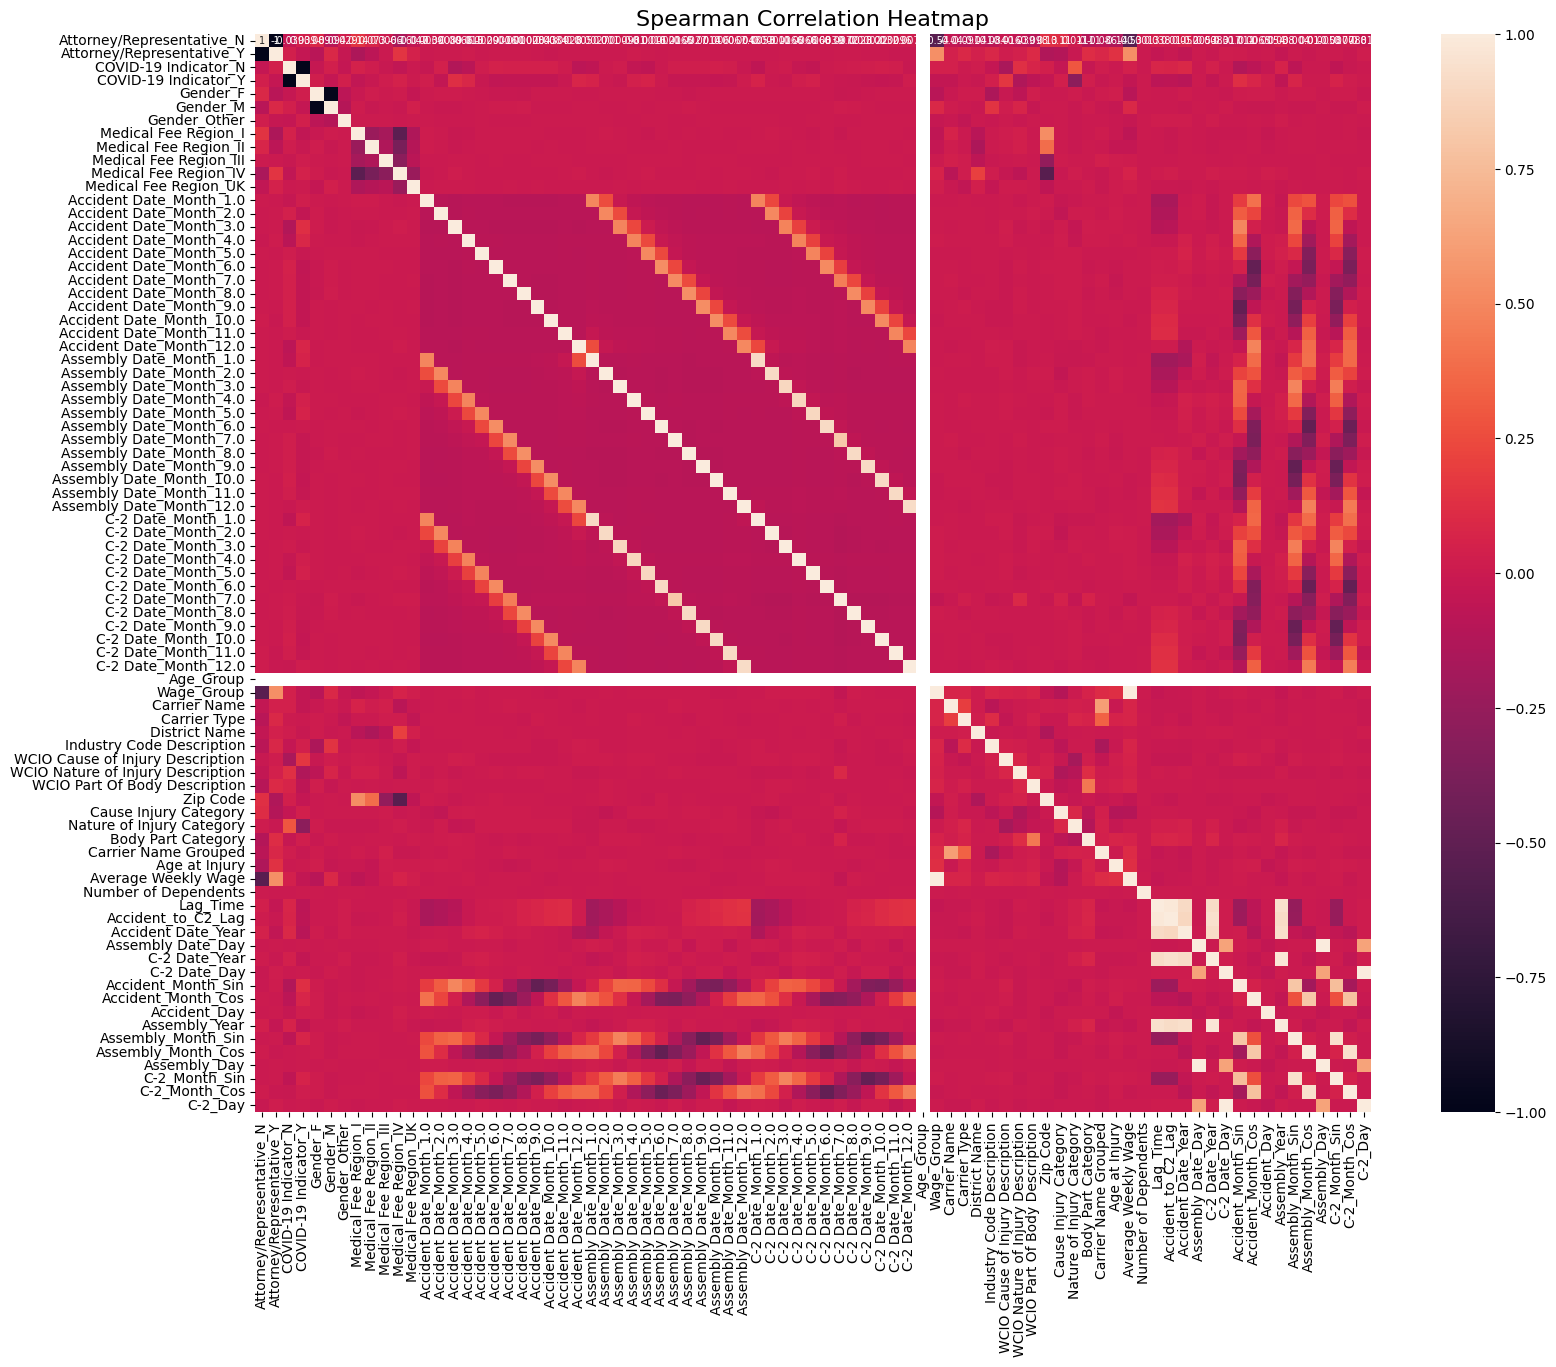

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the correlation heatmap
fig, ax = plt.subplots(figsize=(18, 14))  # Adjust figsize as needed
sns.heatmap(
    cor_spearman,
    xticklabels=cor_spearman.columns,
    yticklabels=cor_spearman.columns,
    annot=True,
    annot_kws={'fontsize': 7},
    ax=ax
)
plt.title("Spearman Correlation Heatmap", fontsize=16)
plt.show()

Correlation Insights

The one-hot encoded binary variables, such as Gender, COVID-19 Indicator, and Medical Fee Region, show perfect negative correlations within their categories (e.g., Gender_F and Gender_M). To avoid redundancy, one of each pair should be removed. The month-related variables (Accident Date_Month, Assembly Date_Month, C-2 Date_Month) and their cyclical transformations (Month_Sin, Month_Cos) are highly correlated, which is expected since these represent cyclical date information for related events occurring close in time. Retaining either the original month variables or their sine/cosine transformations would be sufficient. Similarly, day-related variables (Accident_Day, Assembly_Day, C-2_Day) are highly correlated, reflecting sequential relationships between events. Combining or normalizing these variables might yield more meaningful features.

A perfect correlation exists between Claim Identifier and Lag_Time, indicating that Claim Identifier captures redundant temporal information. Thus, it should be removed in favor of Lag_Time. There is also a notable correlation between Attorney/Representative and Average Weekly Wage, suggesting that individuals with higher wages are more likely to have legal representation. Both variables should be retained, but their interaction may warrant further exploration during modeling. Additionally, variables related to Medical Fee Region show strong internal correlations, so retaining one category per region is recommended to reduce redundancy.

In summary, redundant one-hot encoded variables should be dropped, along with Claim Identifier. Cyclical date features should be reduced to either the original month variables or their sine/cosine transformations. Investigate the relationships between day-related variables and normalize them if appropriate. Finally, keep both Attorney/Representative and Average Weekly Wage, as their correlation might add predictive value. These steps will help streamline the feature set while preserving critical information.

### 4.4 Lasso Regression

In [22]:

# Inspect y_train
print(type(y_train))  # Confirm it's a Series
print("y_train name:", y_train.name)  # Get the name of the Series

# Define target mapping
target_mapping = {
    '1. CANCELLED': 0,
    '2. NON-COMP': 1,
    '3. MED ONLY': 2,
    '4. TEMPORARY': 3,
    '5. PPD SCH LOSS': 4,
    '6. PPD NSL': 5,
    '7. PTD': 6,
    '8. DEATH': 7
}

# Apply the mapping to y_train, y_val, and y_test
y_train = y_train.replace(target_mapping).astype(float)
y_val = y_val.replace(target_mapping).astype(float)
y_test = y_test.replace(target_mapping).astype(float)

# Verify the mapping
print("Mapped y_train unique values:", y_train.unique())

<class 'pandas.core.series.Series'>
y_train name: Claim Injury Type
Mapped y_train unique values: [0. 2. 4. 1. 3. 5. 7. 6.]


In [25]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Train LassoCV
lasso = LassoCV(alphas=np.logspace(-4, 1, 50), cv=5, random_state=42)
lasso.fit(X_train_df_scaled, y_train)

from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler



# Initialize and fit LassoCV
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X_train_df_scaled, y_train)

# Predict on validation set
y_pred = lasso.predict(X_val_df_scaled)

# Evaluate
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Print results
print(f"Optimal alpha: {lasso.alpha_}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")


/Users/pedrocosta/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.261e+03, tolerance: 4.590e+01
  model = cd_fast.enet_coordinate_descent(


Optimal alpha: 0.0008899989944676437
Mean Squared Error: 0.3957
R^2 Score: 0.6882


In [26]:
# Predict on the test set
y_pred = lasso.predict(X_test_df_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

# Print coefficients
print("Lasso Coefficients:")
print(lasso.coef_)

Mean Squared Error (MSE): 0.39637044707655017
R^2 Score: 0.6876336017312098
Lasso Coefficients:
[-2.89313575e-01  0.00000000e+00  3.51327773e-02 -2.14495787e-17
  4.83687675e-03 -0.00000000e+00 -4.33942929e-03  2.85972960e-02
  1.91600302e-02 -8.08162534e-04 -0.00000000e+00 -1.13225274e-02
  1.23602365e-03 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  1.29611088e-04  7.53783152e-04  3.56661190e-04 -0.00000000e+00
 -2.58291082e-03 -1.35195761e-03 -0.00000000e+00  0.00000000e+00
  9.57230430e-04  1.72040566e-03 -0.00000000e+00 -3.74848023e-03
 -6.69223193e-03  1.80343597e-03  3.92639070e-02 -0.00000000e+00
 -6.81994493e-03 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  1.34376710e-01  1.13824913e-01  6.66238206e-02 -0.00000000e+00
 -6.36734979e-02 -1.24388805e-01 -2.00374056e-01 -1.21700785e-01
 -6.01375397e-02  0.00000000e+00  6.59344725e-02  1.11669570e-01
  0.00000000e+00  7.30458850e-01  4.25683929e-03 -1.56687982e-02
  3.07331561e-03 -4.95808060e-03  7.80659184e-03 -7.8799845

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `lasso` is your trained model and `X_train_df_scaled` is the transformed DataFrame
coef = pd.Series(lasso.coef_, index=X_train_df_scaled.columns)

# Sort coefficients by importance
coef_sorted = coef.sort_values()

# Plot feature importance
def plot_importance(coef, model_name):
    plt.figure(figsize=(10, 12))
    coef.plot(kind="barh")
    plt.title(f"Feature Importance using {model_name}")
    plt.show()

plot_importance(coef_sorted, "Lasso")

NameError: name 'reg' is not defined

In [ ]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [ ]:
plot_importance(coef,'Lasso')